[*********************100%***********************]  1 of 1 completed
Best look-back period: 20
Best holding period: 100
Max Sharpe ratio: 16.71


<AxesSubplot:title={'center':'Optimal Momentum Strategy'}, xlabel='Date'>

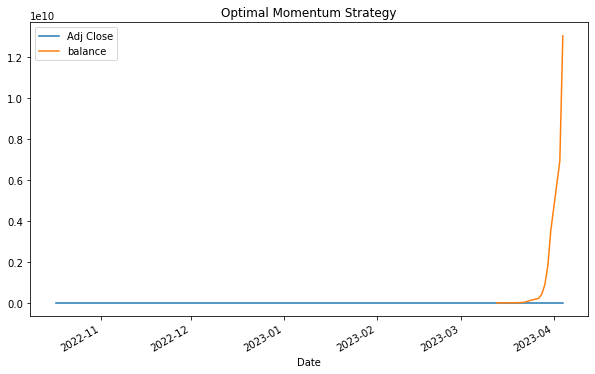

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

# Load NVDA price data
start_date = '2022-10-15'
end_date = '2023-04-05'
ticker = 'NVDA'
data = yf.download(ticker, start=start_date, end=end_date)

# Define parameters
balance = 100000
look_back_periods = [1, 3, 7, 20, 50]
holding_periods = [1, 3, 7, 20, 50, 100]
max_sharpe = -np.inf
best_lb = 0
best_hp = 0

# Compute historical returns for each combination of parameters
for lb in look_back_periods:
    for hp in holding_periods:
        # Compute momentum indicator
        data['return'] = data['Adj Close'].pct_change(periods=lb)
        # Compute signal
        data['signal'] = np.where(data['return']>0, 1, -1)
        # Compute portfolio returns
        data['strategy_return'] = data['signal'].shift(1) * data['Adj Close'].pct_change(periods=hp)
        # Compute portfolio balance
        data['balance'] = (1 + data['strategy_return']).cumprod() * balance
        # Compute Sharpe ratio
        sharpe_ratio = data['strategy_return'].mean() / data['strategy_return'].std()
        # Update max Sharpe ratio and best parameters if applicable
        if sharpe_ratio > max_sharpe:
            max_sharpe = sharpe_ratio
            best_lb = lb
            best_hp = hp

# Compute optimal strategy using best parameters
data['return'] = data['Adj Close'].pct_change(periods=best_lb)
data['signal'] = np.where(data['return']>0, 1, -1)
data['strategy_return'] = data['signal'].shift(1) * data['Adj Close'].pct_change(periods=best_hp)
data['balance'] = (1 + data['strategy_return']).cumprod() * balance

# Print best parameters and max Sharpe ratio
print(f'Best look-back period: {best_lb}')
print(f'Best holding period: {best_hp}')
print(f'Max Sharpe ratio: {max_sharpe:.2f}')

# Plot historical returns of the optimal strategy
data[['Adj Close', 'balance']].plot(figsize=(10,6), title='Optimal Momentum Strategy')


In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Set initial balance
balance = 100000

# Load NVDA price data
ticker = "NVDA"
start_date = "2022-10-15"
end_date = "2023-04-05"
prices = yf.download(ticker, start=start_date, end=end_date)["Adj Close"]

# Set up look-back periods and holding periods
lookback_periods = [1, 3, 7, 20, 50]
holding_periods = [1, 3, 7, 20, 50, 100]

# Create a DataFrame to store the results
results = pd.DataFrame(columns=["lookback_period", "holding_period", "return", "sharpe_ratio"])

# Loop over all possible combinations of look-back periods and holding periods
for lookback_period in lookback_periods:
    for holding_period in holding_periods:
        
        # Compute the momentum signal
        momentum = prices.pct_change(periods=lookback_period).shift(-lookback_period)
        
        # Buy and hold positions based on the momentum signal
        signal = np.sign(momentum)
        position = signal.shift(1)
        
        # Calculate the daily returns of the strategy
        daily_returns = position * prices.pct_change(periods=holding_period)
        
        # Calculate the cumulative returns and the final balance
        cum_returns = (1 + daily_returns).cumprod()
        final_balance = balance * cum_returns[-1]
        
        # Calculate the annualized return and the annualized volatility
        years = (cum_returns.index[-1] - cum_returns.index[0]).days / 365
        total_return = (final_balance / balance) - 1
        annualized_return = (1 + total_return) ** (1 / years) - 1
        daily_volatility = daily_returns.std()
        annualized_volatility = daily_volatility * np.sqrt(252)
        
        # Calculate the Sharpe ratio
        sharpe_ratio = annualized_return / annualized_volatility
        
        # Add the results to the DataFrame
        results = results.append({
            "lookback_period": lookback_period,
            "holding_period": holding_period,
            "return": total_return,
            "sharpe_ratio": sharpe_ratio
        }, ignore_index=True)

# Find the combination with the highest Sharpe ratio
best_combination = results.iloc[results["sharpe_ratio"].idxmax()]

# Compute the momentum signal for the best combination
momentum = prices.pct_change(periods=int(best_combination["lookback_period"])).shift(-int(best_combination["lookback_period"]))

# Buy and hold positions based on the momentum signal
signal = np.sign(momentum)
position = signal.shift(1)

# Calculate the daily returns of the strategy
daily_returns = position * prices.pct_change(periods=int(best_combination["holding_period"]))

# Calculate the cumulative returns and the final balance
cum_returns = (1 + daily_returns).cumprod()
final_balance = balance * cum_returns[-1]

# Calculate the annualized return and the annualized volatility
years = (cum_returns.index[-1] - cum_returns.index[0]).days / 365
total_return = (final_balance / balance) - 1
annualized_return = (1 + total_return) ** (1 / years) - 1
daily_volatility = daily_returns.std()
annualized_volatility = daily_volatility * np.sqrt(365*years)
print('Annualized return: ',annualized_return)
print('Daily volatility: ',daily_volatility)
print('Annualized Volatility return: ',annualized_volatility)

[*********************100%***********************]  1 of 1 completed
Annualized return:  3642.7397990290187
Daily volatility:  0.09193191325168089
Annualized Volatility return:  1.1951148722718516


In [7]:
print('Initial Balance: ',100000)
print('Final Balance: ',final_balance)

Initial Balance:  100000
Final Balance:  4457026.479507787


In [12]:
# Find the combination of look-back and holding periods that maximize the Sharpe ratio
max_sharpe_ratio = results["sharpe_ratio"].max()
best_combination = results.loc[results["sharpe_ratio"] == max_sharpe_ratio]
best_combination

,lookback_period,holding_period,return,sharpe_ratio
2,1.0,7.0,43.570265,2496.097709


Historical return of the strategy:


<AxesSubplot:xlabel='Date'>

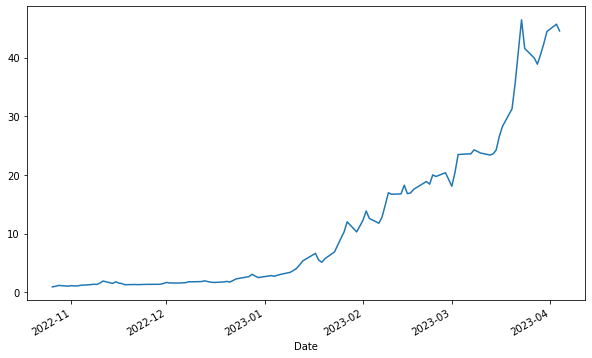

In [13]:

# Print the results
print("Historical return of the strategy:")
cum_returns.plot(figsize=(10, 6))

[*********************100%***********************]  1 of 1 completed
Best look-back period: 50
Best holding period: 1
Best Sharpe ratio: 6.522808002739007


<AxesSubplot:xlabel='Date'>

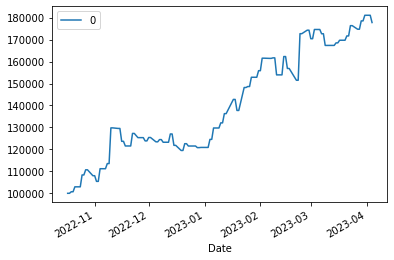

In [47]:
import pandas as pd
import numpy as np
import yfinance as yf

# set initial balance and load data

ticker = 'NVDA'
data = yf.download(ticker, start='2022-10-15', end='2023-04-05')
prices = data['Adj Close']
returns = prices.pct_change().fillna(0)

# set up look-back and holding periods
look_back_periods = [1, 3, 7, 20, 50]
holding_periods = [1, 3, 7, 20, 50, 100]

# initialize sharpe ratio and best parameters
sharpe_ratio = -np.inf
best_lb = None
best_hp = None
best_history=[]
# iterate through all combinations of look-back and holding periods
for lb in look_back_periods:
    for hp in holding_periods:
        balance = 100000
        # initialize variables for tracking trades and P&L
        trades = []
        position = 0
        pnl = []
        temp=np.inf
        # iterate through the price data
        liquidation=[]
        for i in range(len(prices)):
            
            # calculate momentum indicator
            momentum = returns.iloc[max(0, i-lb):i+1].mean()
            # check if we need to sell
            if position > 0 and i - temp >= hp:
                trades.append((prices.index[i], prices.iloc[i], 'SELL'))
                balance += prices.iloc[i] * position
                position = 0
                pnl.append(balance - 100000)
                
            # check if we need to buy
            elif balance>0 and momentum > 0:
                temp=i
                position = balance // prices.iloc[i]
                trades.append((prices.index[i], prices.iloc[i], 'BUY'))
                balance -= prices.iloc[i] * position
            liquidation.append(balance+position*prices.iloc[i])
        #print(liquidation)
        # calculate sharpe ratio for this combination of look-back and holding periods
        daily_returns = pd.Series(liquidation).pct_change().fillna(0)
        annualized_return = (1 + daily_returns.mean())**252 - 1
        annualized_volatility = daily_returns.std() * np.sqrt(252)
        sharpe = annualized_return / annualized_volatility
        # update best parameters if this sharpe ratio is higher
        if sharpe > sharpe_ratio:
            #print(liquidation)
            sharpe_ratio = sharpe
            best_lb = lb
            best_hp = hp
            best_history = liquidation
            
# print results
print('Best look-back period:', best_lb)
print('Best holding period:', best_hp)
print('Best Sharpe ratio:', sharpe_ratio)

# visualize historical return of the strategy
best_history=pd.DataFrame(np.array(best_history),index=prices.index)
best_history.plot()
